---
# T-Rex tile locations
---
Original script written by Yunyi Cheng and re-written by Alex Nguyen. This script removes some of the scoring functions that were found not to be useful.

Version 1 of this script, which requires tile boundaries at codon positions. In future version, this will be relaxed.
Current version does not attempt to remove overhangs that may re-ligate. Need to be updated soon.

---
# Import libraries
---

Install biopython and primer3:
pip install biopython
pip install primer3-py

On Windows, primer3 installation is a bit more complicated. Follow the <a href='https://libnano.github.io/primer3-py/quickstart.html'>instructions</a>.

In [1]:
# Code to optimize tile locations
import os
import numpy as np
import pandas as pd
import itertools as iter
from Bio.Seq import Seq
from itertools import combinations,product
import primer3
import re
import random
import matplotlib.pyplot as plt 
import math

---
# Enter sequence information
---

In [2]:
# Input sequence data
# You must make sure the promoter does not cause a palindrome.
# The palindrome would be C ATG for the promoter
# Be careful with a terminator starting with A as that often creates overhangs that do not ligate (TAA A, for example)
# TAGA also does not ligate, so recommend TGAA or ensuring the first base of the terminator is a different base or change the stop codon

gene_name = "AmpR"
promoter = "tggcacttttcggggaaatgtgcgcggaacccctatttgtttatttttctaaatacattcaaatatgtatccgctcatgagacaataaccctgataaatgcttcaataatattgaaaaaggaagagt" # 
sequence = "atgagtattcaacatttccgtgtcgcccttattcccttttttgcggcattttgccttcctgtttttgctcacccagaaacgctggtgaaagtaaaagatgctgaagatcagttgggtgcacgagtgggttacatcgaactggatctcaacagcggtaagatccttgagagttttcgccccgaagaacgttttccaatgatgagcacttttaaagttctgctatgtggcgcggtattatcccgtattgacgccgggcaagagcaactcggtcgccgcatacactattctcagaatgacttggttgagtactcaccagtcacagaaaagcatcttacggatggcatgacagtaagagaattatgcagtgctgccataaccatgagtgataacactgcggccaacttacttctgacaacgatcggaggaccgaaggagctaaccgcttttttgcacaacatgggggatcatgtaactcgccttgatcgttgggaaccggagctgaatgaagccataccaaacgacgagcgtgacaccacgatgcctgtagcaatggcaacaacgttgcgcaaactattaactggcgaactacttactctagcttcccggcaacaattaatagactggatggaggcggataaagttgcaggaccacttctgcgctcggcccttccggctggctggtttattgctgataaatctggagccggtgagcgtggttctcgcggtatcattgcagcactggggccagatggtaagccctcccgtatcgtagttatctacacgacggggagtcaggcaactatggatgaacgaaatagacagatcgctgagataggtgcctcactgattaagcattggtaa";
terminator = "ctgtcagaccaagtttactcatatatactttagattgatttaaaacttcatttttaatttaaaagga";

promoter = promoter.upper()
sequence = sequence.upper()
terminator = terminator.upper()

mutate_first_methionine = 0; # Set to 1 if you want to mutate it. That means the tile will be on the left side of the methionine.

# Some stop codons and terminator combinations are not conducive to TRex mutagenesis. In those case, we'll shift the tile on triplet to the right but not mutate the stop codon
# We need a check for this
shift_stop_codon = 0     # Set this to 1 if you always want to shift it
if(sequence[-3:] + terminator[1] == "TAAA" or sequence[-3:] + terminator[1] == "TAGA"):
    shift_stop_codon = 1
    


In [3]:
seq_len = len(sequence)
seq_AA_len = seq_len / 3
print(seq_AA_len)

287.0


---
# Choose the number of tiles
---
Run the cost calculator to have a cost estimate of the library given the number of tiles. The minimum number of tiles is provided, which is calculated from the maximum size for Ultramers. Ultramers are expected to be between 100 bp and 300 bp, and we have tried to aim for oligos about 200 bp in size. The maximum number of tiles is calculated based on the number of overhangs that exist (256). Some of these overhangs do not ligate and some are palindromic. The total number of overhangs in the set is approximately four times the number of tiles, which means that the max number of tiles is about 60. We recommend multiple pools instead of trying to do all the assembly in a single tube.

Note that the cost estimate does not include the fact that more reagents are needed for more reactions, and that labor becomes more complicated to manage. The user should use the least number of tiles that is manageable.

In [4]:
# Oligo cost per bp for <60bp oligos
oligo_cost_per_bp = 0.2
oPools_rebate = 0.87857

# oPools pricing is (as of 2022)
# 140$ for the first 3300 bases
# 4 cents per bp for bases 3301 to 50000
# 3 cents per bp for bases 50001 to 100000
# 1 cents per bp for the rest

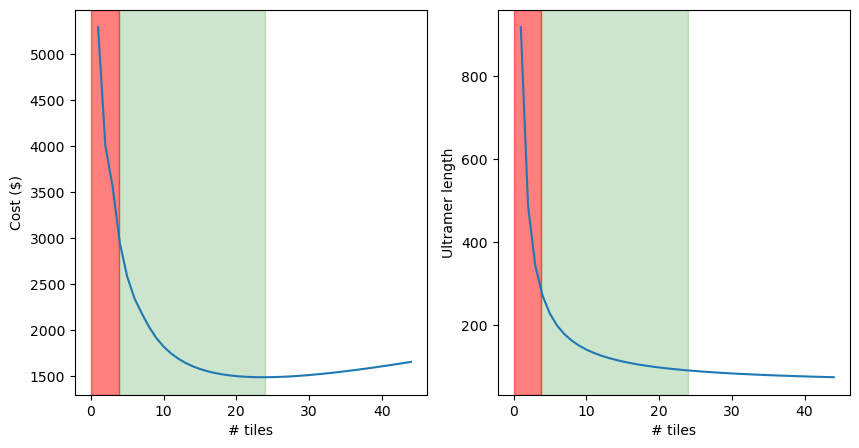

Consider from 4 to 24 tiles.


In [5]:
ccdB_cost = 89*oligo_cost_per_bp
total_cost = []
dna_size = []
ccdB_cost_vector = []
tile_cost_vector = []
min_i = 100
min_i_cost = 1000000
for i in range(1, 100):
    # Number of tiles is i
    AA_length_per_tile = seq_AA_len / i
    DNA_length_oligo_per_tile = AA_length_per_tile * 3 + 56
    total_DNA_length_to_order = DNA_length_oligo_per_tile * AA_length_per_tile * i
    dna_size.append(DNA_length_oligo_per_tile)
    ccdB = ccdB_cost * i
    oPools = oPools_rebate * (147 + 0.046*max(0,min(50000,total_DNA_length_to_order) - 3300) + 0.035*max(0,min(100000,total_DNA_length_to_order) - 50000) + 0.012*max(0,total_DNA_length_to_order - 100000))
    cost = ccdB + oPools
    total_cost.append(cost)
    ccdB_cost_vector.append(ccdB)
    tile_cost_vector.append(oPools)
    if(cost < min_i_cost):
        min_i = i
        min_i_cost = cost
    
# Plot cost
max_x_to_show = min_i + 20
xpoints = np.array(range(1,max_x_to_show+1))
ypoints = np.array(total_cost[0:max_x_to_show])

#plt.plot(xpoints, ypoints)
#plt.axvspan(0, seq_AA_len/75, alpha=0.5, color='red')
#plt.axvspan(seq_AA_len/75,min_i, alpha=0.2, color='green')
#plt.show()
plt.rcParams['figure.figsize'] = [10, 5]
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(xpoints, ypoints)
ax1.axvspan(0, seq_AA_len/75, alpha=0.5, color='red')
ax1.axvspan(seq_AA_len/75,min_i, alpha=0.2, color='green')
ax1.set_xlabel('# tiles')
ax1.set_ylabel('Cost ($)')

ax2.plot(xpoints,np.array(dna_size[0:max_x_to_show]))
ax2.axvspan(0, seq_AA_len/75, alpha=0.5, color='red')
ax2.axvspan(seq_AA_len/75,min_i, alpha=0.2, color='green')
ax2.set_xlabel('# tiles')
ax2.set_ylabel('Ultramer length')


plt.show()

print("Consider from " + str(math.ceil(seq_AA_len/75)) + " to " + str(min_i) + " tiles.")



In [6]:
# Set the number of tile.
tile_count = 6
print(total_cost[tile_count])
print(ccdB_cost_vector[tile_count])
print(tile_cost_vector[tile_count])

2183.3135453499995
124.60000000000001
2058.7135453499995


In [7]:
# Scan positions that cannot be tile boundaries which means that the overlap region codes for a BsaI site when NNK is present at the boundaries
# BsaI sites are GAGACC, or GGTCTC and PmeI sites are GTTTAAAC
# Here's how we do this.
# NNK or NNS are NN[GT] or NN[GC]
# This means that the only case where we can have a problem are:
# NN[KS] | AGA CCN
# NN[KS] | GTC TCN
# NN[KS] | TCT C
# G GTC | NN[KS]
# G AGA | NN[KS]
# NN[KS] | ACC N
# GG TCT | NN[KS]
# GA GAC | NN[KS]
# NN[KS] | TTT AAA C
# G TTT AAA | NN[KS]
# GTT TAA | NN[KS] <- not possible because TAA is a stop codon

bad_pos = []
for i in range(3,int(seq_AA_len)):
	# Does it match the patterns?
	# Convert to DNA position
	DNA_pos = int((i-1) * 3)
	#print(str(i) + "\t" + sequence[DNA_pos:DNA_pos+4])
	#print(str(i) + "\t" + sequence[DNA_pos-4:DNA_pos])
	
	if(sequence[DNA_pos:DNA_pos+5] == "AGACC" or 
       sequence[DNA_pos:DNA_pos+5] == "GTCTC" or 
       sequence[DNA_pos:DNA_pos+4] == "TCTC" or 
       sequence[DNA_pos-4:DNA_pos] == "GGTC" or 
       sequence[DNA_pos-4:DNA_pos] == "GAGA" or 
       sequence[DNA_pos:DNA_pos+3] == "ACC" or 
       sequence[DNA_pos-5:DNA_pos] == "GGTCT" or 
       sequence[DNA_pos-5:DNA_pos] == "GAGAC" or 
       (sequence+terminator)[DNA_pos:DNA_pos+7] == "TTTAAAC" or
       sequence[DNA_pos-7:DNA_pos] == "GTTTAAA"):
		bad_pos.append(i)


def rc(st):
    nn = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
    return "".join(nn[n] for n in reversed(st))
	
def get_overhangs(tile_pos):
    overhangs = []
    for pos in tile_pos:
        if(pos == 2):
            oh_l = promoter[-1] + sequence[0:3]	
            #oh_r = sequence[3:7]	

            overhangs.append(oh_l)
            overhangs.append(rc(oh_l))

        elif(pos == 1):
            oh_l = promoter[-4:]
            #oh_r = sequence[3:7]	

            overhangs.append(oh_l)
            overhangs.append(rc(oh_l))
        elif(pos == seq_AA_len):
            oh_r = sequence[-3:] + terminator[0]
            #oh_l = sequence[-7:-3]
            overhangs.append(oh_r)
            overhangs.append(rc(oh_r))

        elif(pos == seq_AA_len + 1):
            oh_r = terminator[0:4]
            overhangs.append(oh_r)
            overhangs.append(rc(oh_r))
        else:
            oh_l = sequence[(pos-1)*3 - 4:(pos-1)*3]
            oh_r = sequence[(pos-1)*3:(pos-1)*3+4]

            overhangs.append(oh_l)
            overhangs.append(rc(oh_l))

            overhangs.append(oh_r)
            overhangs.append(rc(oh_r))

    return(overhangs)

def get_overhang_scores(overhangs):
	# What is the score based only on overhangs?
	# It's the combination of on-target and off-target
	# So we grab all possible combinations of overhangs and calculate the sum of scores
	off_reaction = 0
	on_reaction = 0
	repetition = 0
	#print(overhangs)
	for i in range(len(overhangs)-1):
		on_flag = 0
		for j in range(i+1,len(overhangs)):
			if(overhangs[i] == rc(overhangs[j]) and on_flag == 0):
				on_flag = 1
				if(df[overhangs[i]][overhangs[j]] != 0):               
					#on_reaction += math.log(df[overhangs[i]][overhangs[j]]/np.sum(df[overhangs[i]]))
					on_reaction += df[overhangs[i]][overhangs[j]]
			else:
				if(df[overhangs[i]][overhangs[j]] != 0):
					#off_reaction += math.log(df[overhangs[i]][overhangs[j]]/np.sum(df[overhangs[i]]))
					off_reaction += df[overhangs[i]][overhangs[j]]
				
			if(overhangs[i] == overhangs[j]):
				# We have a repetition
				#print(overhangs[i] + "\t" + overhangs[j])
				repetition += 1

	# Get the number of palindromes
	palindromes = 0
	for oh in overhangs:
		if(oh == rc(oh)):
			#print(oh)
			palindromes += 1
			
	# Get the number of non-ligation overhangs
	no_ligation = ['TCTA','TAGA','TTAT','ATAA','TTGA','TCAA','TATA','TTTA','TAAA','TTAA']
	no_lig_count = 0
	for oh in overhangs:
		if(oh in no_ligation):
			no_lig_count += 1
			
	return (on_reaction, off_reaction, palindromes/2, repetition - palindromes/2, no_lig_count)
	
def get_distances(tile_pos):
	dist = []
	for i in range(len(tile_pos)-1):
		dist.append(tile_pos[i+1] - tile_pos[i])
		
	return (dist)

def score(tile_pos, debug = 0):
	on_reaction, off_reaction, palindromes, repetition, no_lig_count = get_overhang_scores(get_overhangs(tile_pos))
	dist = np.array(get_distances(tile_pos))
	dist_score = np.sum((dist - avrg_tile_length)**2)
	
	bad_pos_flag = 0
	if(any(np.isin(np.array(tile_pos),np.array(bad_pos)))):
		bad_pos_flag = 1

    # Change the weight for scores here!
	final_score = on_reaction - off_reaction - palindromes*100000 - repetition * 100000 - dist_score * 5 - bad_pos_flag * 100000 - no_lig_count * 100000
	if debug == 1:
		print(get_overhangs(tile_pos)) 
		print("On\tOff\tPalindromes\tRepetition\tDistance\tBad Loc\tBad ligation\tFinal Score")
		print(str(on_reaction) + "\t" + str(off_reaction) + "\t" + str(palindromes) + "\t" + str(repetition) + "\t" + str(dist_score) + "\t" + str(bad_pos_flag) + "\t" + str(no_lig_count) + "\t" + str(final_score))
	
	return(final_score)

In [8]:
# Import the overhang fidelity chart
path_name = "NEB_overhang_fidelity.xlsx"
while not os.path.isfile(path_name):
    path_name = input("Whoops! No such file! Please enter the name of the file you'd like to use.")
# read the excel file into pandas dataframe
df = pd.read_excel(path_name, sheet_name='S1 Table. BsaI-HFv2', engine='openpyxl')
# set overhang as indices for indexing the chart by row + col names
df.set_index("Overhang", inplace = True)

# First let's talk convention
# A tile at position 2 is right after the first ATG codon (or right before the second codon). That is, tile positions are in codon space.

# Second, what is our strategy?
# We first randomly select tile positions, but we enforce the first and last tile position to be position 2 and the last possible position.

avrg_tile_length = (seq_AA_len-2) / tile_count

---
# Tile location optimization
---

You can rerun the optimization, or change the max_iter variable if you are unhappy with the scores.
<br><br>
**The final score MUST be positive before you proceed!**

[2, 47, 95, 142, 190, 237, 287]
['TATG', 'CATA', 'CGAA', 'TTCG', 'CTGG', 'CCAG', 'ACAC', 'GTGT', 'TATT', 'AATA', 'CGGA', 'TCCG', 'GGAC', 'GTCC', 'GCGC', 'GCGC', 'AAAC', 'GTTT', 'CGGT', 'ACCG', 'GAGC', 'GCTC', 'TAAC', 'GTTA']
On	Off	Palindromes	Repetition	Distance	Bad Loc	Bad ligation	Final Score
42042	1244	1.0	0.0	13.5	0	0	-59269.5
-59269.5
[2, 47, 95, 142, 188, 237, 287]
0	41739.5
[2, 47, 95, 143, 188, 237, 287]
2	42832.5
[2, 47, 99, 143, 188, 237, 287]
4	44093.5
[2, 47, 102, 143, 188, 237, 287]
5	44189.5
[2, 49, 102, 143, 188, 237, 287]
8	44965.5
[2, 52, 102, 143, 188, 237, 287]
13	44968.5
[2, 52, 99, 143, 188, 237, 287]
14	45413.5
['TATG', 'CATA', 'CAGC', 'GCTG', 'GGTA', 'TACC', 'GAAT', 'ATTC', 'GACT', 'AGTC', 'AGGA', 'TCCT', 'CCGA', 'TCGG', 'AACG', 'CGTT', 'TTGC', 'GCAA', 'CGGT', 'ACCG', 'GAGC', 'GCTC', 'TAAC', 'GTTA']
On	Off	Palindromes	Repetition	Distance	Bad Loc	Bad ligation	Final Score
45793	212	0.0	0.0	33.5	0	0	45413.5
45413.5


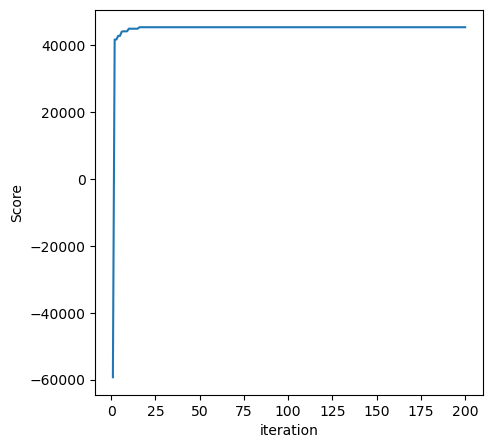

In [9]:
max_iter = 200

# Initialize tile positions
if(mutate_first_methionine == 1):
	tile_pos = [1]
else:
	tile_pos = [2]
    
for i in range(tile_count - 1):
	tile_pos.append(int(avrg_tile_length * (i+1)))

if(shift_stop_codon == 1):
    tile_pos.append(int(seq_AA_len + 1))
else:
    tile_pos.append(int(seq_AA_len))

print(tile_pos)
# Get scores for all the overhangs of current position
curr_score = score(tile_pos,debug = 1)
print(curr_score)
# Ok now we optimize!
all_scores = []
for iteration in range(max_iter):
	# Randomly choose a position
	random_pos = random.randint(1,tile_count-2)	
	#print(random_pos)
	# Scan all the possible tile neighborhoods
	max_score = -1*np.Infinity
	max_pos = 0
	for i in range(max(tile_pos[random_pos-1]+5, tile_pos[random_pos] - 5),min(tile_pos[random_pos+1] - 5,tile_pos[random_pos] + 5)):
		tmp_pos = tile_pos[:]
		tmp_pos[random_pos] = i
		tmp_score = score(tmp_pos)
		if(tmp_score > max_score):
			max_score = tmp_score
			max_pos = i
	all_scores.append(curr_score)
	# Did it change?
	if(max_score > curr_score):
		# Modify the tile position
		tile_pos[random_pos] = max_pos
		curr_score = max_score
	
		print(tile_pos)
		print(str(iteration) + "\t" + str(curr_score))
	
	
print(score(tile_pos,debug=1))

xpoints = np.array(range(1,max_iter+1))
ypoints = np.array(all_scores)

plt.rcParams['figure.figsize'] = [5, 5]
fig, ax1 = plt.subplots()
ax1.plot(xpoints, ypoints)
ax1.set_xlabel('iteration')
ax1.set_ylabel('Score')

plt.show()


In [10]:
#tile_pos = [2, 28, 49, 75, 108, 144, 162, 189, 214, 237, 266]
# Save your output here, or else you will not get the same tile locations if you rerun the script!
# If you want to ensure your script always gives the same output, use a seed for the random function!
tile_pos

[2, 52, 99, 143, 188, 237, 287]

---
# ccdB cloning primers
---

With the tile positions in place, we can now create all the ccdB cloning primers to create the entry plasmids.

In [11]:
# Once we have the tile positions, we generate the primers
# First, the ccdB cloning primers.
# How does it work? Suppose we have positions 2, 10, 24
# We have a tile between 2 and 10 so we create a primer that starts at position 2 and going left, and a primer that starts at position 10 and going right
full_DNA = promoter + sequence + terminator
for i in range(tile_count):
	# Tile is from tile_pos[i] to tile_pos[i+1]
	# Grab DNA position
	# DNA position for a tile position is:
	#print(str(tile_pos[i]) + "\t" + str(tile_pos[i+1]))
	
	# Left side
	for l in range(20,40):
		# Scan for primer size
		putative_primer = full_DNA[(tile_pos[i]-1) * 3 + len(promoter)-l:(tile_pos[i]-1) * 3 + len(promoter)]
		if(primer3.calc_tm(putative_primer, dv_conc=2,mv_conc=130,dna_conc=500) > 58):
			# Primer length is correct
			# Stop and append primer
			print("ccdBdown>" + gene_name + "-Tile" + str(i+1) + "-R" + "\t" + "CTCCCTTATACACAGCCggtctca " + rc(putative_primer))
			break
	
	# Right side
	for l in range(20,40):
		putative_primer = full_DNA[(tile_pos[i+1]-1) * 3 + len(promoter):(tile_pos[i+1]-1) * 3 + len(promoter) + l]
		if(primer3.calc_tm(putative_primer, dv_conc=2,mv_conc=130,dna_conc=500) > 58):
			# Primer length is correct
			# Stop and append primer
			print("ccdBup>" + gene_name + "-Tile" + str(i+1) + "-F" + "\t" + "TACTGTTATCTGGCTTggtctca " + putative_primer)
			break

ccdBdown>AmpR-Tile1-R	CTCCCTTATACACAGCCggtctca CATACTCTTCCTTTTTCAATATTATTGAA
ccdBup>AmpR-Tile1-F	TACTGTTATCTGGCTTggtctca GGTAAGATCCTTGAGAGTTTTCG
ccdBdown>AmpR-Tile2-R	CTCCCTTATACACAGCCggtctca GCTGTTGAGATCCAGTTCGA
ccdBup>AmpR-Tile2-F	TACTGTTATCTGGCTTggtctca GACTTGGTTGAGTACTCACC
ccdBdown>AmpR-Tile3-R	CTCCCTTATACACAGCCggtctca ATTCTGAGAATAGTGTATGCGG
ccdBup>AmpR-Tile3-F	TACTGTTATCTGGCTTggtctca CCGAAGGAGCTAACCGCTTT
ccdBdown>AmpR-Tile4-R	CTCCCTTATACACAGCCggtctca TCCTCCGATCGTTGTCAGAA
ccdBup>AmpR-Tile4-F	TACTGTTATCTGGCTTggtctca TTGCGCAAACTATTAACTGG
ccdBdown>AmpR-Tile5-R	CTCCCTTATACACAGCCggtctca CGTTGTTGCCATTGCTACAG
ccdBup>AmpR-Tile5-F	TACTGTTATCTGGCTTggtctca GAGCGTGGTTCTCGCGGTAT
ccdBdown>AmpR-Tile6-R	CTCCCTTATACACAGCCggtctca ACCGGCTCCAGATTTATCAG
ccdBup>AmpR-Tile6-F	TACTGTTATCTGGCTTggtctca TAACTGTCAGACCAAGTTTACT


---
# Oligo pool production
---

In [12]:
# Done building the tile cloning primers.
# Now build the tile replacement oligos
prepend_sequence = "AGCGGA GGTCTC a " # Minimum of 2 base is needed. We do 6 here.
tailend_sequence = " t GAGACC GTCATAGCTGTTTCCTG"

In [13]:
# Codon usage table
codon_usage = {}
codon_usage["TTT"] = 26.1
codon_usage["TCT"] = 23.5
codon_usage["TAT"] = 18.8
codon_usage["TGT"] = 8.1
codon_usage["TTC"] = 18.4
codon_usage["TCC"] = 14.2
codon_usage["TAC"] = 14.8
codon_usage["TGC"] = 4.8
codon_usage["TTA"] = 26.2
codon_usage["TCA"] = 18.7
codon_usage["TAA"] = 1.1
codon_usage["TGA"] = 0.7
codon_usage["TTG"] = 27.2
codon_usage["TCG"] = 8.6
codon_usage["TAG"] = 0.5
codon_usage["TGG"] = 10.4
codon_usage["CTT"] = 12.3
codon_usage["CCT"] = 13.5
codon_usage["CAT"] = 13.6
codon_usage["CGT"] = 6.4
codon_usage["CTC"] = 5.4
codon_usage["CCC"] = 6.8
codon_usage["CAC"] = 7.8
codon_usage["CGC"] = 2.6
codon_usage["CTA"] = 13.4
codon_usage["CCA"] = 18.3
codon_usage["CAA"] = 27.3
codon_usage["CGA"] = 3
codon_usage["CTG"] = 10.5
codon_usage["CCG"] = 5.3
codon_usage["CAG"] = 12.1
codon_usage["CGG"] = 1.7
codon_usage["ATT"] = 30.1
codon_usage["ACT"] = 20.3
codon_usage["AAT"] = 35.7
codon_usage["AGT"] = 14.2
codon_usage["ATC"] = 17.2
codon_usage["ACC"] = 12.7
codon_usage["AAC"] = 24.8
codon_usage["AGC"] = 9.8
codon_usage["ATA"] = 17.8
codon_usage["ACA"] = 17.8
codon_usage["AAA"] = 41.9
codon_usage["AGA"] = 21.3
codon_usage["ATG"] = 20.9
codon_usage["ACG"] = 8
codon_usage["AAG"] = 30.8
codon_usage["AGG"] = 9.2
codon_usage["GTT"] = 22.1
codon_usage["GCT"] = 21.2
codon_usage["GAT"] = 37.6
codon_usage["GGT"] = 23.9
codon_usage["GTC"] = 11.8
codon_usage["GCC"] = 12.6
codon_usage["GAC"] = 20.2
codon_usage["GGC"] = 9.8
codon_usage["GTA"] = 11.8
codon_usage["GCA"] = 16.2
codon_usage["GAA"] = 45.6
codon_usage["GGA"] = 10.9
codon_usage["GTG"] = 10.8
codon_usage["GCG"] = 6.2
codon_usage["GAG"] = 19.2
codon_usage["GGG"] = 6

# Convert tile positions to DNA positions
DNA_tile_pos = []
for tile in range(len(tile_pos)):
	DNA_tile_pos.append((tile_pos[tile]-1)*3)
    
#if(shift_stop_codon == 1):
#    DNA_tile_pos[-1] = DNA_tile_pos[-1]-3



In [14]:
def mutate_NNKS(seq,pos,nnk_flag):
	mut_seq = seq[:]
	permut = []
	
	if(nnk_flag == 1):
		# Convert seq location to NNK
		permut = [['A', 'T', 'C', 'G'], ['A', 'T', 'C', 'G'], ['G', 'T']]
	else:
		# Convert to NNS
		permut = [['A', 'T', 'C', 'G'], ['A', 'T', 'C', 'G'], ['G', 'C']]
	permut = list(iter.product(*permut))
	permut = [''.join(tup) for tup in permut]
	error_flag = 0
	for i in range(len(permut)):
		#mut_seq[pos:pos+3] = permut[i]
		
		mut_seq = mut_seq[:pos] + permut[i] + mut_seq[pos+3:]
		#print(permut[i])
		# Check if match BsaI/PmeI
		# If it does, it means NNK is not valid at this position with the current sequence
		new_site = re.findall(r'GGTCTC|GAGACC|GTTTAAAC', mut_seq)
		#print(new_site)
		#print(mut_seq[:pos] + "\t" + permut[i] + "\t" + mut_seq[pos+3:])
		if any(new_site):
			error_flag = 1
			break
			
	return error_flag
	
	
def modify_wild(seq,pos,tile_left_flag,tile_right_flag):
	# The strategy is to systematically try synonymous codons before and after the position of interest
	# Then we test if it matches NNK (or NNS) using the mutate_NNK/NNS function
	# If it passes the test, then we store the codon usage and that change as a potential change.
	# Once we go through all the possible changes, we keep the best change.
	# Return whether we modified before or after the position, and the synonymous codon
	#mut_seq = seq[:]
	
	# Grab the codon before the position
	codon_before = seq[pos-3:pos]
	AA_before = Seq(codon_before).translate()
	
	codon_after = seq[pos+3:pos+6]
	AA_after = Seq(codon_after).translate()
	
	curr_usage = 6.4 # minimum codon usage acceptance
	potential_codon = ""
	nnk_flag = -1
	before_flag = -1
	
	# We must also check if it's possible to change the codon before or after (cannot change overhangs, which means we can't change at tile boundaries.
	for codons in codon_usage:
		if(tile_left_flag == 0 and codons != codon_before and Seq(codons).translate() == AA_before and codon_usage[codons] > curr_usage):
			# Mutate
			mut_seq = seq[:pos-3] + codons + seq[pos:]
			#print(codons + "\t" + str(before_flag) + "\t" + str(nnk_flag))
			#print(mutate_NNKS(mut_seq,pos,1))         
			# Now check if it causes a BsaI site with NNK
			if(not(mutate_NNKS(mut_seq,pos,1))):
				# Does not cause BsaI
				curr_usage = codon_usage[codons]
				potential_codon = codons
				before_flag = 1
				nnk_flag = 1
				
			# Now check if it causes a BsaI site with NNS
			elif(not(mutate_NNKS(mut_seq,pos,0))):
				# Does not cause BsaI
				curr_usage = codon_usage[codons]
				potential_codon = codons
				before_flag = 1
				nnk_flag = 0
		#print(codons + "\t" + str(before_flag) + "\t" + str(nnk_flag))
		if(tile_right_flag == 0 and codons != codon_after and Seq(codons).translate() == AA_after and codon_usage[codons] > curr_usage):
			# Mutate
			mut_seq = seq[:pos+3] + codons + seq[pos+6:]
			
			# Now check if it causes a BsaI site with NNK
			if(not(mutate_NNKS(mut_seq,pos,1))):
				# Does not cause BsaI
				curr_usage = codon_usage[codons]
				potential_codon = codons
				before_flag = 0
				nnk_flag = 1
				
			# Now check if it causes a BsaI site with NNS
			elif(not(mutate_NNKS(mut_seq,pos,0))):
				# Does not cause BsaI
				curr_usage = codon_usage[codons]
				potential_codon = codons
				before_flag = 0
				nnk_flag = 0
		
	return(potential_codon,before_flag,nnk_flag)

def modify_both_wild(seq,pos):
    # The strategy is to systematically try synonymous codons for both positions before and after
    # Then we test if it matches NNK (or NNS) using the mutate_NNK/NNS function
    # If it passes the test, then we store the codon usages and that change as a potential change.
    # Once we go through all the possible changes, we keep the best change.
    # Return whether we modified before or after the position, and the synonymous codon
    #mut_seq = seq[:]

    # Grab the codon before the position
    codon_before = seq[pos-3:pos]
    AA_before = Seq(codon_before).translate()

    codon_after = seq[pos+3:pos+6]
    AA_after = Seq(codon_after).translate()

    curr_usage = 6.4 # minimum codon usage acceptance
    potential_codon_left = ""
    potential_codon_right = ""
    nnk_flag = -1
    
    try_left = []
    try_right = []
    
    for codons in codon_usage:
        if(codons != codon_before and Seq(codons).translate() == AA_before and codon_usage[codons] > curr_usage):
            try_left.append(codons)

        if(codons != codon_after and Seq(codons).translate() == AA_after and codon_usage[codons] > curr_usage):
            try_right.append(codons)
            
    # Now make all combinations of left/right
    for combin in iter.product(try_left,try_right):
        #print(combin[0] + "\t" + combin[1])
        # Mutate
        mut_seq = seq[:pos-3] + combin[0] + seq[pos:pos+3] + combin[1] + seq[pos+6:]
        
        # Now check if it causes a BsaI site with NNK
        if(not(mutate_NNKS(mut_seq,pos,1))):
            # Does not cause BsaI
            if(min(codon_usage[combin[0]],codon_usage[combin[1]]) > curr_usage):
                curr_usage = min(codon_usage[combin[0]],codon_usage[combin[1]])
                potential_codon_left = combin[0]
                potential_codon_right = combin[1]
                nnk_flag = 1

        # Now check if it causes a BsaI site with NNS
        elif(not(mutate_NNKS(mut_seq,pos,0))):
            # Does not cause BsaI
            if(min(codon_usage[combin[0]],codon_usage[combin[1]]) > curr_usage):
                curr_usage = min(codon_usage[combin[0]],codon_usage[combin[1]])
                potential_codon_left = combin[0]
                potential_codon_right = combin[1]
                nnk_flag = 0
            
    return(potential_codon_left,potential_codon_right,nnk_flag)

In [15]:
for tile in range(tile_count):
    #print(DNA_tile_pos[tile])
    #continue
    for i in range(DNA_tile_pos[tile],DNA_tile_pos[tile+1],3):

        if((i+3)/3 == seq_AA_len):
            continue
        
        if(DNA_tile_pos[tile] < 1):
            left_oh = promoter[-4:]
        elif(DNA_tile_pos[tile] < 4):
            left_oh = promoter[-1] + sequence[DNA_tile_pos[tile]-3:DNA_tile_pos[tile]]
        else:
            left_oh = sequence[DNA_tile_pos[tile]-4:DNA_tile_pos[tile]]

        right_oh = (sequence+terminator)[DNA_tile_pos[tile+1]:DNA_tile_pos[tile+1]+4]


        # Steps: mutate to NNK
        NNK_mut_err = mutate_NNKS(sequence,i,1)
        if(not(NNK_mut_err)):
            # NNK works
            oligo_name = 'Tile{}_{}{}NNK'.format(tile+1, Seq(sequence[i:i+3]).translate(), int((i+3)/3))
            oligo_seq = prepend_sequence + left_oh + " " + sequence[DNA_tile_pos[tile]:i] + "NNK" + sequence[i+3:DNA_tile_pos[tile+1]] + " " + right_oh + tailend_sequence

            print(oligo_name + "\t" + oligo_seq)
            continue

        # Second try: mutate to NNS
        NNS_mut_err = mutate_NNKS(sequence,i,0)
        if(not(NNS_mut_err)):
            oligo_name = 'Tile{}_{}{}NNS'.format(tile+1, Seq(sequence[i:i+3]).translate(), int((i+3)/3))
            oligo_seq = prepend_sequence + left_oh + " " + sequence[DNA_tile_pos[tile]:i] + "NNS" + sequence[i+3:DNA_tile_pos[tile+1]] + " " + right_oh + tailend_sequence

            print(oligo_name + "\t" + oligo_seq)
            continue

        # Third try: mutation codons before/after and then NNK
        tile_left_flag = 0
        tile_right_flag = 0
        if(i == DNA_tile_pos[tile]):
            tile_left_flag = 1
        if(i == DNA_tile_pos[tile+1]-3):
            tile_right_flag = 1

        mut_wild_codon, before_pos, nnk_flag = modify_wild(sequence,i,tile_left_flag,tile_right_flag)
        if(before_pos != -1):
            if(before_pos == 1):
                if(nnk_flag == 1):
                    # Modifying the codon before the NNK works
                    oligo_name = 'Tile{}_{}{}*NNK'.format(tile+1, Seq(sequence[i:i+3]).translate(), int((i+3)/3))
                    oligo_seq = prepend_sequence + left_oh + " " + sequence[DNA_tile_pos[tile]:i-3] + mut_wild_codon + "NNK" + sequence[i+3:DNA_tile_pos[tile+1]] + " " + right_oh + tailend_sequence
                elif(nnk_flag == 0):
                    # Modifying the codon before the NNS works
                    oligo_name = 'Tile{}_{}{}*NNS'.format(tile+1, Seq(sequence[i:i+3]).translate(), int((i+3)/3))
                    oligo_seq = prepend_sequence + left_oh + " " + sequence[DNA_tile_pos[tile]:i-3] + mut_wild_codon + "NNS" + sequence[i+3:DNA_tile_pos[tile+1]] + " " + right_oh + tailend_sequence

            elif(before_pos == 0):
                if(nnk_flag == 1):
                    # Modifying the codon after the NNK works
                    oligo_name = 'Tile{}_{}{}NNK*'.format(tile+1, Seq(sequence[i:i+3]).translate(), int((i+3)/3))
                    oligo_seq = prepend_sequence + left_oh + " " + sequence[DNA_tile_pos[tile]:i]  + "NNK" + mut_wild_codon + sequence[i+6:DNA_tile_pos[tile+1]] + " " + right_oh + tailend_sequence
                elif(nnk_flag == 0):
                    # Modifying the codon after the NNS works
                    oligo_name = 'Tile{}_{}{}NNS*'.format(tile+1, Seq(sequence[i:i+3]).translate(), int((i+3)/3))
                    oligo_seq = prepend_sequence + left_oh + " " + sequence[DNA_tile_pos[tile]:i]  + "NNS" + mut_wild_codon + sequence[i+6:DNA_tile_pos[tile+1]] + " " + right_oh + tailend_sequence

            print(oligo_name + "\t" + oligo_seq)
            continue

        # Forth try, mutate both before and after
        mut_wild_codon_left, mut_wild_codon_right, nnk_flag = modify_both_wild(sequence,i)
        if(nnk_flag == 1):
            # Modifying for NNK works
            oligo_name = 'Tile{}_{}{}*NNK*'.format(tile+1, Seq(sequence[i:i+3]).translate(), int((i+3)/3))
            oligo_seq = prepend_sequence + left_oh + " " + sequence[DNA_tile_pos[tile]:i-3] + mut_wild_codon_left + "NNK" + mut_wild_codon_right + sequence[i+6:DNA_tile_pos[tile+1]] + " " + right_oh + tailend_sequence
            print(oligo_name + "\t" + oligo_seq)
        elif(nnk_flag == 0):
            # Modifying for NNS works
            oligo_name = 'Tile{}_{}{}*NNS*'.format(tile+1, Seq(sequence[i:i+3]).translate(), int((i+3)/3))
            oligo_seq = prepend_sequence + left_oh + " " + sequence[DNA_tile_pos[tile]:i-3] + mut_wild_codon_left + "NNS" + mut_wild_codon_right + sequence[i+6:DNA_tile_pos[tile+1]] + " " + right_oh + tailend_sequence
            print(oligo_name + "\t" + oligo_seq)

Tile1_S2NNK	AGCGGA GGTCTC a TATG NNKATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGGCATTTTGCCTTCCTGTTTTTGCTCACCCAGAAACGCTGGTGAAAGTAAAAGATGCTGAAGATCAGTTGGGTGCACGAGTGGGTTACATCGAACTGGATCTCAACAGC GGTA t GAGACC GTCATAGCTGTTTCCTG
Tile1_I3NNK	AGCGGA GGTCTC a TATG AGTNNKCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGGCATTTTGCCTTCCTGTTTTTGCTCACCCAGAAACGCTGGTGAAAGTAAAAGATGCTGAAGATCAGTTGGGTGCACGAGTGGGTTACATCGAACTGGATCTCAACAGC GGTA t GAGACC GTCATAGCTGTTTCCTG
Tile1_Q4NNK	AGCGGA GGTCTC a TATG AGTATTNNKCATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGGCATTTTGCCTTCCTGTTTTTGCTCACCCAGAAACGCTGGTGAAAGTAAAAGATGCTGAAGATCAGTTGGGTGCACGAGTGGGTTACATCGAACTGGATCTCAACAGC GGTA t GAGACC GTCATAGCTGTTTCCTG
Tile1_H5NNK	AGCGGA GGTCTC a TATG AGTATTCAANNKTTCCGTGTCGCCCTTATTCCCTTTTTTGCGGCATTTTGCCTTCCTGTTTTTGCTCACCCAGAAACGCTGGTGAAAGTAAAAGATGCTGAAGATCAGTTGGGTGCACGAGTGGGTTACATCGAACTGGATCTCAACAGC GGTA t GAGACC GTCATAGCTGTTTCCTG
Tile1_F6NNK	AGCGGA GGTCTC a TATG AGTATTCAACATNNKCGTGTCGCCCTTATTCCCTTTTTTGCGGCATTTTGCCTTCCTGTTTTTGCTCACCCAGAAACGCTGGTGAAAGTAAAAGATGCTGAAG